### Running Eazy-py on the Riverside test catalogs

In [1]:
%matplotlib inline
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from astropy.table import Table

from astropy.utils.exceptions import AstropyWarning
import warnings
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

### Prepare catalogs

In [2]:
## Replace extraneous tabs with spaces
os.system('perl -pi -e "s/\t/ /g" CANDELS_GDSS_worksho*[p1].dat')

## Make flux columns
files = glob.glob('*[p1].dat')
for file in files:
    cat = Table.read(file, format='ascii.commented_header')

    for err_col in cat.colnames:
        if err_col.startswith('e'):
            mag_col = err_col[1:]

            flux = 10**(-0.4*(cat[mag_col]-25))
            flux_err = np.log(10)/2.5*cat[err_col]

            bad = (cat[mag_col] < -90)
            bad |= cat[mag_col] > 90

            flux[bad] = -99
            flux_err[bad] = -99

            cat['flux_'+mag_col] = flux
            cat['err_'+mag_col] = flux_err

            # For translate file
            #print('flux_{0:<11s} F00\nerr_{0:<12s} E00'.format(mag_col))

    cat.write(file.replace('.dat','.flux.fits'), overwrite=True)


In [3]:
# Link templates and filter files 
# EAZYCODE is an environment variable that points to the the eazy-photoz distribution
eazy.symlink_eazy_inputs(path='EAZYCODE', path_is_env=True)

/usr/local/share/eazy-photoz/templates -> ./templates
/usr/local/share/eazy-photoz/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [4]:
### filter translation file

# Not sure about CTIO_U
trans = """ID id
zz z_spec
flux_CTIO_U      F107
err_CTIO_U       E107
flux_VIMOS_U     F103
err_VIMOS_U      E103
flux_ACS_F435W   F233
err_ACS_F435W    E233
flux_ACS_F606W   F236
err_ACS_F606W    E236
flux_ACS_F775W   F238
err_ACS_F775W    E238
flux_ACS_F814W   F239
err_ACS_F814W    E239
flux_ACS_F850LP  F240
err_ACS_F850LP   E240
flux_WFC3_F098M  F201
err_WFC3_F098M   E201
flux_WFC3_F105W  F202
err_WFC3_F105W   E202
flux_WFC3_F125W  F203
err_WFC3_F125W   E203
flux_WFC3_F160W  F205
err_WFC3_F160W   E205
flux_ISAAC_KS    F37
err_ISAAC_KS     E37
flux_HAWKI_KS    F269
err_HAWKI_KS     E269
flux_IRAC_CH1    F18
err_IRAC_CH1     E18
flux_IRAC_CH2    F19
err_IRAC_CH2     E19
flux_IRAC_CH3    F20
err_IRAC_CH3     E20
flux_IRAC_CH4    F21
err_IRAC_CH4     E21"""

fp = open('zphot.translate.gdss','w')
fp.write(trans)
fp.close()

### Run the photo-z fits

In [5]:
# Galactic extinction
EBV = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 'uds':0.0195, 'goodsn':0.0103}['goodss']
    
roots = ['CANDELS_GDSS_workshop', 'CANDELS_GDSS_workshop_z1'][1:]

for root in roots:
    print('\n####\n')
    params = {}

    params['CATALOG_FILE'] = '{0}.flux.fits'.format(root)
    params['MAIN_OUTPUT_FILE'] = '{0}.eazypy'.format(root)

    params['PRIOR_FILTER'] = 205
    params['PRIOR_ABZP'] = 25
    params['MW_EBV'] = EBV

    params['Z_MAX'] = 12
    params['Z_STEP'] = 0.01

    params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
    
    params['VERBOSITY'] = 1
    
    ez = eazy.photoz.PhotoZ(param_file=None,
                              translate_file='zphot.translate.gdss',
                              zeropoint_file=None, params=params,
                              load_prior=True, load_products=False)

    for iter in range(2):
      ez.fit_parallel(n_proc=4)
      ez.error_residuals()

    print('Get physical parameters')
    ez.standard_output()


####

Read default param file: /Users/brammer/.local/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: CANDELS_GDSS_workshop_z1.flux.fits
flux_CTIO_U err_CTIO_U (107): ESO/wfi_BB_U38_ESO841.res
flux_VIMOS_U err_VIMOS_U (103): ESO/vimos_u.res
flux_ACS_F435W err_ACS_F435W (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
flux_ACS_F606W err_ACS_F606W (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
flux_ACS_F775W err_ACS_F775W (238): hst/ACS_update_sep07/wfc_f775w_t81.dat
flux_ACS_F814W err_ACS_F814W (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
flux_ACS_F850LP err_ACS_F850LP (240): hst/ACS_update_sep07/wfc_f850lp_t81.dat
flux_WFC3_F098M err_WFC3_F098M (201): hst/wfc3/IR/f098m.dat
flux_WFC3_F105W err_WFC3_F105W (202): hst/wfc3/IR/f105w.dat
flux_WFC3_F125W err_WFC3_F125W (203): hst/wfc3/IR/f125w.dat
flux_WFC3_F160W err_WFC3_F160W (205): hst/wfc3/IR/f160w.dat
flux_ISAAC_KS err_ISAAC_KS ( 37): ESO/isaac_ks.res
flux_HAWKI_KS err_HAWKI_KS (269): VLT/hawki_k_ETC.dat
flux_IR

/Users/brammer/.local/lib/python3.5/site-packages/eazy/photoz.py:1742: RuntimeWarning: covariance is not positive-semidefinite.
  coeffs_draw[:, ok_temp] = np.random.multivariate_normal(coeffs_i[ok_temp], covar, size=get_err)


In [12]:
# Outputs for the z=1 catalog
zout = Table.read('{0}.zout.fits'.format(params['MAIN_OUTPUT_FILE']))
zout['ssfr'] = zout['SFR']/zout['mass']
print(zout.colnames)

['id', 'z_spec', 'nusefilt', 'numpeaks', 'z_phot', 'z_phot_chi2', 'z_phot_risk', 'z_min_risk', 'min_risk', 'z_chi2_noprior', 'chi2_noprior', 'z025', 'z160', 'z500', 'z840', 'z975', 'restU', 'restU_err', 'restB', 'restB_err', 'restV', 'restV_err', 'restJ', 'restJ_err', 'Lv', 'MLv', 'Av', 'mass', 'SFR', 'LIR', 'line_flux_Ha', 'line_EW_Ha', 'line_flux_O3', 'line_EW_O3', 'line_flux_Hb', 'line_EW_Hb', 'line_flux_O2', 'line_EW_O2', 'line_flux_Lya', 'line_EW_Lya', 'ssfr']


### Diagnostic plots

/Users/brammer/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


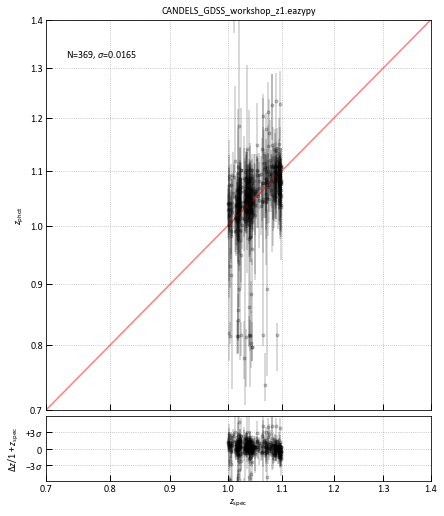

In [7]:
fig = ez.zphot_zspec(zmin=0.7, zmax=1.4, minor=0.1, skip=0)

In [14]:
### UVJ
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])

uverr = 2.5*np.sqrt((zout['restU_err']/zout['restU'])**2+(zout['restV_err']/zout['restV'])**2)
vjerr = 2.5*np.sqrt((zout['restV_err']/zout['restV'])**2+(zout['restJ_err']/zout['restJ'])**2)

/Users/brammer/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/brammer/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


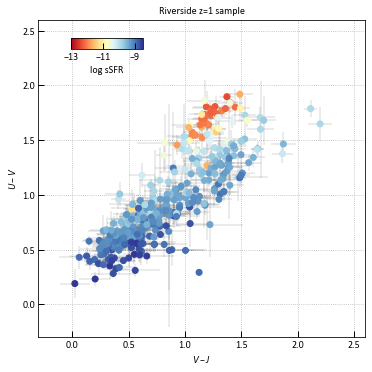

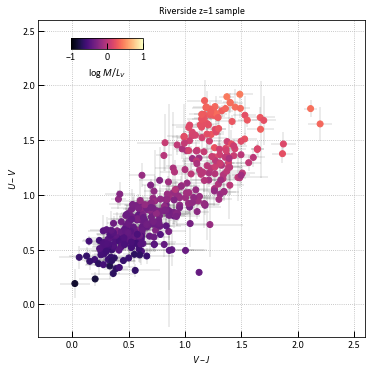

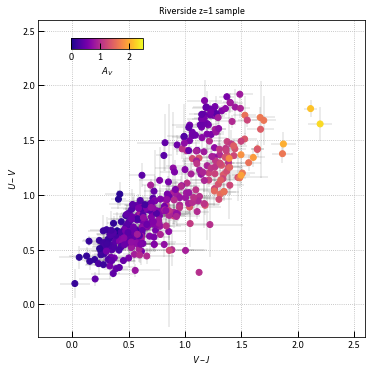

In [15]:
for show in ['ssfr', 'MLv', 'Av']:
    
    fig = plt.figure(figsize=[5,5])
    
    ax = fig.add_subplot(111)
    ax.errorbar(vj, uv, xerr=vjerr, yerr=uverr, color='k', 
                alpha=0.1, marker='.', capsize=0, linestyle='None')
    
    if show == 'ssfr':
        sc = ax.scatter(vj, uv, c=np.log10(zout['ssfr']), 
                        vmin=-13, vmax=-8.5, zorder=10, cmap='RdYlBu')
        label = 'log sSFR'
        ticks = np.arange(-13,-8,2)
    
    elif show == 'MLv':
        sc = ax.scatter(vj, uv, c=np.log10(zout['MLv']), 
                        vmin=-1, vmax=1, zorder=10, cmap='magma')
        label = r'$\log\ M/L_V$'
        ticks = np.arange(-1,1.1,1)

    elif show == 'Av':
        sc = ax.scatter(vj, uv, c=zout['Av'], vmin=0, 
                        vmax=2.5, zorder=10, cmap='plasma')
        label = r'$A_V$'
        ticks = np.arange(0,2.1,1)
    
    # Colorbar
    cax = fig.add_axes((0.18, 0.88, 0.2, 0.03))
    cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
    cb.set_label(label)
    cb.set_ticks(ticks)
    
    ax.set_xlim(-0.3, 2.6)
    ax.set_ylim(-0.3, 2.6)
    
    ax.grid()
    
    ax.set_xlabel(r'$V-J$'); ax.set_ylabel(r'$U-V$')
    ax.set_title('Riverside z=1 sample')
    
    fig.tight_layout(pad=0.1)
    
    plt.savefig('Riverside_z1_{0}.pdf'.format(show))

/Users/brammer/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


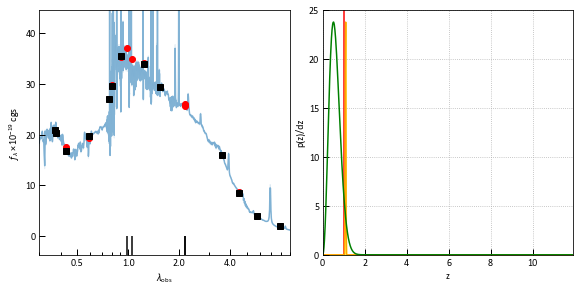

In [10]:
# Show SED
id_i = ez.cat['id'][4]
fig = ez.show_fit(id_i, show_fnu=0)

/Users/brammer/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(0, 2)

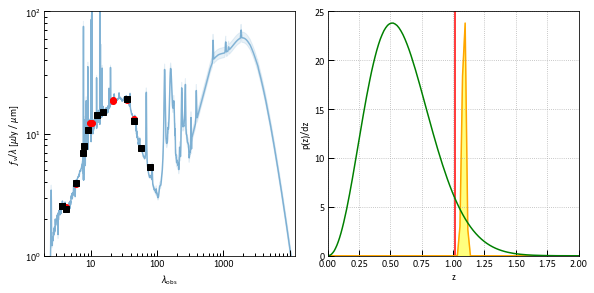

In [11]:
# nu-Fnu scaling for far-IR 
fig = ez.show_fit(id_i, show_fnu=2)

fig.axes[0].set_xlim(0.2, 1200)
fig.axes[0].set_ylim(1, 100)
fig.axes[0].loglog()
fig.axes[0].set_xticklabels([0.1, 1, 10, 100, 1000])
fig.axes[1].set_xlim(0, 2)